In [1]:
pip install Flask


In [ ]:
# Import Packages

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tqdm import tqdm

In [2]:
class_names = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___healthy','Potato___Late_blight','Tomato__Target_Spot','Tomato__Tomato_mosaic_virus','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_healthy','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

Found 1501 images belonging to 15 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


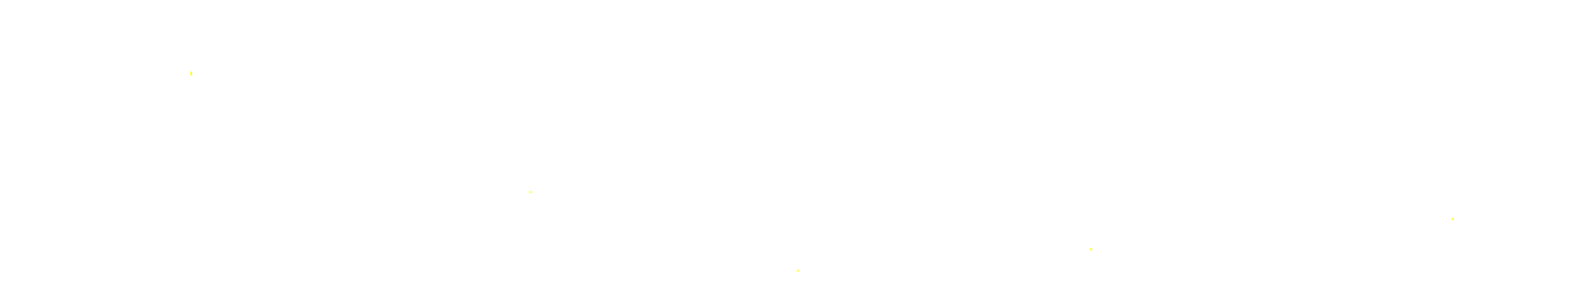

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories containing your training images
train_dir = 'C:/Users/Narayana/Desktop/pepper/pepper leaf/dataset/train'

# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation up to 20 degrees
    width_shift_range=0.2,  # Random horizontal shift by up to 20% of the image width
    height_shift_range=0.2, # Random vertical shift by up to 20% of the image height
    shear_range=0.2,        # Shear intensity (shear angle in radians)
    zoom_range=0.2,         # Random zoom up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=True,     # Randomly flip images vertically
    fill_mode='nearest'     # Fill mode for points outside the input boundaries
)

# Flow training images in batches of 32 using data augmentation
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=32,
    class_mode='categorical'  # Assuming your labels are one-hot encoded
)

# Visualize some augmented images
augmented_images = [train_generator[0][0][0] for _ in range(5)]
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, image in enumerate(augmented_images):
    axes[i].imshow(image)
    axes[i].axis('off')
plt.show()


# Loading the Data
We have to write a load_data function that load the images and the labels from the folder.

In [4]:
def load_data():

    datasets = ['C:/Users/Narayana/Desktop/pepper/pepper leaf/dataset/train', 'C:/Users/Narayana/Desktop/pepper/pepper leaf/dataset/test']

    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output

In [6]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Users/Narayana/Desktop/pepper/pepper leaf/dataset/train


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 324.75it/s]


Loading C:/Users/Narayana/Desktop/pepper/pepper leaf/dataset/test


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 299.83it/s]


In [7]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [8]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 1501
Number of testing examples: 1501
Each image is of size: (150, 150)


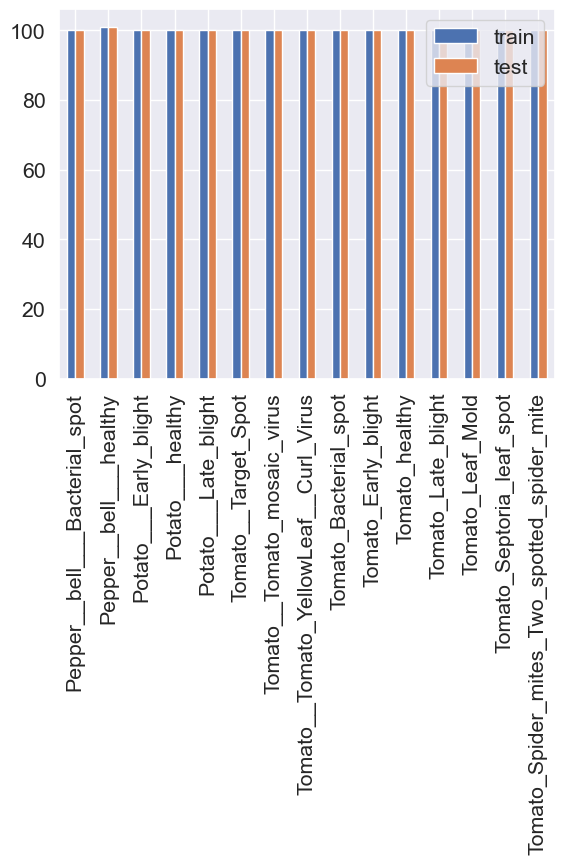

In [9]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=class_names
            ).plot.bar()
plt.show()

In [10]:
train_images = train_images / 255.0
test_images = test_images / 255.0 

In [11]:
def display_examples(class_names, images, labels):
    """
        Display 5 images from the images array with its corresponding labels
    """

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(5):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]],fontsize=8)
    plt.show()

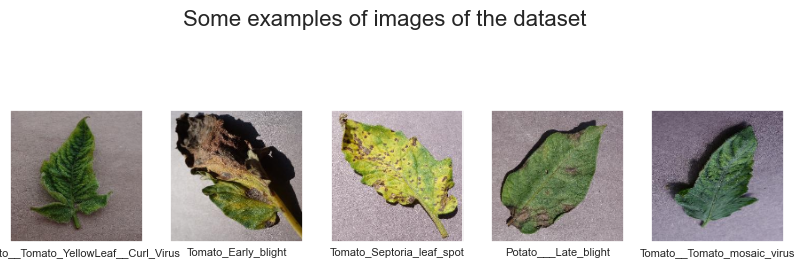

In [12]:
    display_examples(class_names, train_images, train_labels)

In [13]:
batch_size =32
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [14]:
import tensorflow as tf

rcnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(15, activation='softmax')
])


C:\Users\Narayana\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [15]:
rcnn_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = rcnn_model.fit(train_images, train_labels, batch_size=128, epochs=15, validation_split = 0.02)

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 564ms/step - accuracy: 0.0651 - loss: 4.7441 - val_accuracy: 0.0968 - val_loss: 2.6955
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - accuracy: 0.0878 - loss: 2.6906 - val_accuracy: 0.1290 - val_loss: 2.5835
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - accuracy: 0.2172 - loss: 2.4465 - val_accuracy: 0.2258 - val_loss: 2.1575
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - accuracy: 0.4690 - loss: 1.7531 - val_accuracy: 0.4194 - val_loss: 1.7757
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 484ms/step - accuracy: 0.5882 - loss: 1.3254 - val_accuracy: 0.4516 - val_loss: 1.4819
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 486ms/step - accuracy: 0.7071 - loss: 0.9440 - val_accuracy: 0.3548 - val_loss: 1.5802
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 480ms/step - accuracy: 0.8153 - loss: 0.6421 - val_accuracy: 0.5484 - val_loss: 1.4031
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - accuracy: 0.8777 - loss: 0.4409 - val_accuracy: 0

In [17]:
    test_loss = rcnn_model.evaluate(test_images, test_labels)

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9919 - loss: 0.0441


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[13]


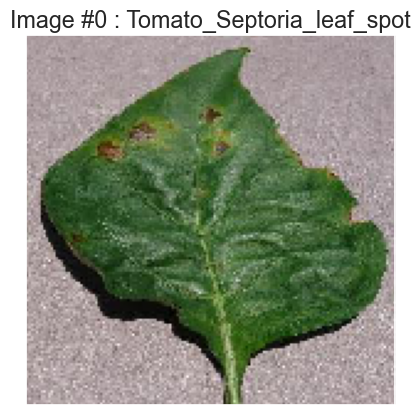

In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
test_image = image.load_img('C:/Users/Narayana/Desktop/pepper/pepper leaf/dataset/test/Pepper__bell___Bacterial_spot/7d2eeb0b-77d8-4de5-8739-adca95edd4a2___JR_B.Spot 8946.JPG', target_size = (150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
predictions = rcnn_model.predict(test_image)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability
print(pred_labels )
index = np.random.randint(test_image.shape[0])
plt.figure()
plt.imshow(test_image[index].astype('uint8'))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title('Image #{} : '.format(index) + class_names[pred_labels[index]])
plt.show()

In [20]:
rcnn_model.save_weights("model_vgg.weights.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
rcnn_model_json=rcnn_model.to_json()
with open("model_vgg.json", "w") as json_file:
    json_file.write(rcnn_model_json)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import tensorflow as tf
from flask import Flask, render_template, request, send_from_directory

app = Flask(__name__)


UPLOAD_FOLDER = "uploads"
STATIC_FOLDER = "static"
json_file = open('model_vgg.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
cnn_model = model_from_json(loaded_model_json)
# load weights into new model
cnn_model.load_weights("model_vgg.weights.h5")
# Load model

IMAGE_SIZE = 150

# Preprocess an image
def preprocess_image(image):
    
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image /= 255.0  # normalize to [0,1] range

    return image


# Read the image from path and preprocess
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)

    return preprocess_image(image)

# Predict & classify image
def classify(model, image_path):

    preprocessed_imgage = load_and_preprocess_image(image_path)
    preprocessed_imgage = tf.reshape(
        preprocessed_imgage, (1, IMAGE_SIZE, IMAGE_SIZE, 3)
    )

    prob = cnn_model.predict(preprocessed_imgage)
    label = "Un Healthy Pepper leaf" if prob[0][0] >= 0.5 else "Healthy Pepper leaf"
    classified_prob = prob[0][0] if prob[0][0] >= 0.5 else 1 - prob[0][0]

    return label, classified_prob




# home page
@app.route("/")
def home():
    return render_template("home.html")


@app.route("/classify", methods=["POST", "GET"])
def upload_file():

    if request.method == "GET":
        return render_template("home.html")

    else:
        file = request.files["image"]
        upload_image_path = os.path.join(UPLOAD_FOLDER, file.filename)
        print(upload_image_path)
        file.save(upload_image_path)

        label, prob = classify(cnn_model, upload_image_path)

        prob = round((prob * 100), 2)

    return render_template(
        "classify.html", image_file_name=file.filename, label=label, prob=prob
    )


@app.route("/classify/<filename>")
def send_file(filename):
    return send_from_directory(UPLOAD_FOLDER, filename)


if __name__ == "__main__":
    
    app.run()
   


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [18/Mar/2024 11:35:25] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2024 11:35:25] "GET /static/script.js HTTP/1.1" 304 -
127.0.0.1 - - [18/Mar/2024 11:35:25] "GET /static/images/pepper.jpeg HTTP/1.1" 304 -
127.0.0.1 - - [18/Mar/2024 11:35:25] "GET /favicon.ico HTTP/1.1" 404 -


uploads\LLLLLLLLLLL.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


127.0.0.1 - - [18/Mar/2024 11:35:31] "POST /classify HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2024 11:35:31] "GET /classify/LLLLLLLLLLL.jpg HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2024 11:35:31] "GET /static/script.js HTTP/1.1" 304 -
127.0.0.1 - - [18/Mar/2024 11:35:31] "GET /static/images/pepper.jpeg HTTP/1.1" 304 -
